In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py"

BATCH_SIZE = 128
NUM_WORKERS = 2

# Unpickle CIFAR-10 files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_data = []
train_labels = []

In [3]:

for i in range(1, 6):
    batch_file = os.path.join(DATA_DIR, f'data_batch_{i}')
    print(f"Loading {batch_file}...")
    batch_dict = unpickle(batch_file)
    data = batch_dict[b'data']
    labels = batch_dict[b'labels']
    train_data.append(data)
    train_labels.extend(labels)

train_data = np.vstack(train_data)
train_labels = np.array(train_labels)

val_batch_file = os.path.join(DATA_DIR, 'test_batch')
val_dict = unpickle(val_batch_file)
val_data = val_dict[b'data']
val_labels = np.array(val_dict[b'labels'])

batches_meta_file = os.path.join(DATA_DIR, 'batches.meta')
print(f"Loading {batches_meta_file}...")
meta_dict = unpickle(batches_meta_file)
class_names = [name.decode('utf-8') for name in meta_dict[b'label_names']]

print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Val data shape: {val_data.shape}")
print(f"Val labels shape: {val_labels.shape}")
print(f"Classes: {class_names}")


Loading /content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_1...
Loading /content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_2...
Loading /content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_3...
Loading /content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_4...
Loading /content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/data_batch_5...
Loading /content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/batches.meta...
Training data shape: (50000, 3072)
Training labels shape: (50000,)
Val data shape: (10000, 3072)
Val labels shape: (10000,)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, class_names, transform=None):
        self.data = data
        self.labels = labels
        self.class_names = class_names
        self.transform = transform

        #  (N, 3072) > (N, 32, 32, 3)
        self.data = self.data.reshape(-1, 3, 32, 32)
        #  (N, C, H, W) > (N, H, W, C) for PIL
        self.data = self.data.transpose(0, 2, 3, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        #numpy array > PIL Image
        image = Image.fromarray(image.astype('uint8'))
        if self.transform:
            image = self.transform(image)

        return image, label

Training batches: 391
val batches: 79


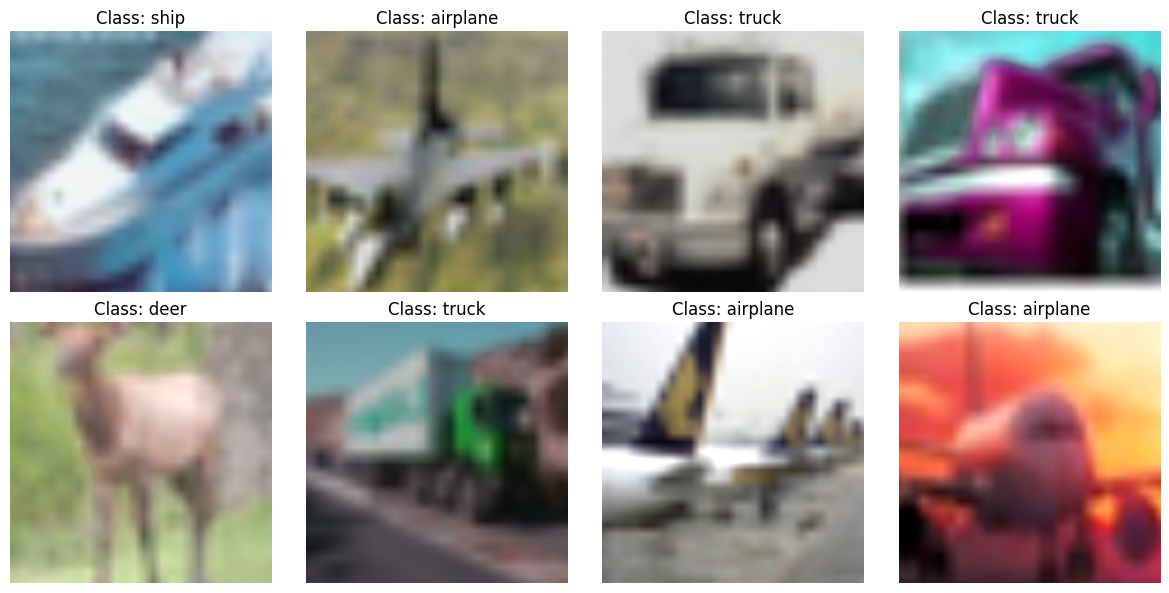

In [5]:

train_transform = transforms.Compose([
    transforms.Resize(256),  # resize to 256x256
    transforms.RandomCrop(227),  # random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])  #  normalization
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])
train_dataset = CIFAR10Dataset(train_data, train_labels, class_names, transform=train_transform)
val_dataset = CIFAR10Dataset(val_data, val_labels, class_names, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Training batches: {len(train_loader)}")
print(f"val batches: {len(val_loader)}")

data_iter = iter(train_loader)
images, labels = next(data_iter)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):

    img = images[i] * std + mean
    img = torch.clamp(img, 0, 1)
    img_np = img.permute(1, 2, 0).numpy()

    axes[i].imshow(img_np)
    axes[i].set_title(f'Class: {class_names[labels[i]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:

batch_count = 0
for images, labels in train_loader:
    print(f"Batch {batch_count + 1}: Images shape: {images.shape}, Labels shape: {labels.shape}")
    batch_count += 1
    if batch_count >= 3:  #showing first 3 batches
        break


print(f"Input image size: {images.shape[1:]} (C, H, W)")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Batch 1: Images shape: torch.Size([128, 3, 227, 227]), Labels shape: torch.Size([128])
Batch 2: Images shape: torch.Size([128, 3, 227, 227]), Labels shape: torch.Size([128])
Batch 3: Images shape: torch.Size([128, 3, 227, 227]), Labels shape: torch.Size([128])
Input image size: torch.Size([3, 227, 227]) (C, H, W)
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Using device: cuda


In [7]:
# class AlexNet(nn.Module):
#   def __init__(self,num_classes=10):
#     super(AlexNet,self).__init__()
#     self.model=nn.Sequential(
#         nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=2),#cl-1
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=3,stride=2),
#         nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),#cl-2
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=3,stride=2),
#         nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),#cl-3
#         nn.ReLU(),
#         nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1),#cl-4
#         nn.ReLU(),
#         nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),#cl-5
#         nn.Relu(),
#         nn.MaxPool2d(kernel_size=3,stride=2)

#     )
#     self.fc=nn.Sequnetial(
#         nn.Flatten(),
#         nn.Linear(256*2*2,4096),
#         nn.Tanh(),
#         nn.Dropout(p=0.5),
#         nn.Linear(4096,4096),
#         nn.Tanh(),
#         nn.Dropout(p=0.5),
#         nn.Linear(4096,num_classes)


#     )
#   def forward(self,x):
#     x=self.model(x)
#     x=self.fc(x)
#     return x


import torch
import torch.nn as nn

class Vgg16(nn.Module):
    def __init__(self, num_classes=10):
        super(Vgg16, self).__init__()
        self.model = nn.Sequential(
            # nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # cl-1 227 -> 55
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2),                  #  55 -> 27

            # nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # cl-2 27 -> 27
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2),                  # 27 -> 13

            # nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),# cl-3 13 -> 13
            # nn.ReLU(),

            # nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),# cl-4 13 -> 13
            # nn.ReLU(),

            # nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),# cl-5 13 -> 13
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=3, stride=2)                   # 13 -> 6
            nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)


        )

        self.fc = nn.Sequential(
            # nn.Flatten(),
            # nn.Linear(256 * 6 * 6, 4096),  # 9216
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(4096, 4096),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(4096, num_classes)
            nn.Flatten(),
            nn.Linear(512*7*7,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x




In [8]:
#0-9
num_classes = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = Vgg16(num_classes).to(device)
print(model)

Using device: cuda
Vgg16(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), 

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Reshape for CNN
            data = data.to(device) # Move data to the device
            targets = targets.to(device)
            #forward
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            # Backward
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data = data.to(device) # Move data to the device
                targets = targets.to(device)

                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += targets.size(0)
                correct_val += (predicted == targets).sum().item()

        # averages
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss}, Train Acc: {train_acc}%')
        print(f'Val Loss: {avg_val_loss}, Val Acc: {val_acc}%')


    return train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/10]
Train Loss: 2.3027978669042173, Train Acc: 10.096%
Val Loss: 2.302864802034595, Val Acc: 10.0%
Epoch [2/10]
Train Loss: 2.3029308642267874, Train Acc: 9.904%
Val Loss: 2.302664599841154, Val Acc: 10.0%
Epoch [3/10]
Train Loss: 2.302897899047188, Train Acc: 9.944%
Val Loss: 2.302676961391787, Val Acc: 10.0%
Epoch [4/10]
Train Loss: 2.3029464474114616, Train Acc: 10.036%
Val Loss: 2.3026269961007033, Val Acc: 10.0%
Epoch [5/10]
Train Loss: 2.302898611863861, Train Acc: 9.878%
Val Loss: 2.302915114390699, Val Acc: 10.0%
Epoch [6/10]
Train Loss: 2.30290706993064, Train Acc: 10.03%
Val Loss: 2.302908462814138, Val Acc: 10.0%
Epoch [7/10]
Train Loss: 2.302913615160891, Train Acc: 9.78%
Val Loss: 2.302775307546688, Val Acc: 10.0%
Epoch [8/10]
Train Loss: 2.3028083402482444, Train Acc: 9.824%
Val Loss: 2.3026934756508357, Val Acc: 10.0%
Epoch [9/10]
Train Loss: 2.3029353441789633, Train Acc: 9.728%
Val Loss: 2.302673267412789, Val Acc: 10.0%
Epoch [10/10]
Train Loss: 2.30287809384

In [12]:

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [13]:

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(data_loader)

    return avg_loss, accuracy, predictions, true_labels



In [14]:

val_loss, val_accuracy, val_predictions, val_true_labels = evaluate_model(
    model, val_loader, criterion, device
)
print(f'Final Validation Loss: {val_loss}')
print(f'Final Validation Accuracy: {val_accuracy}%')

Final Validation Loss: 2.30278854732272
Final Validation Accuracy: 10.0%


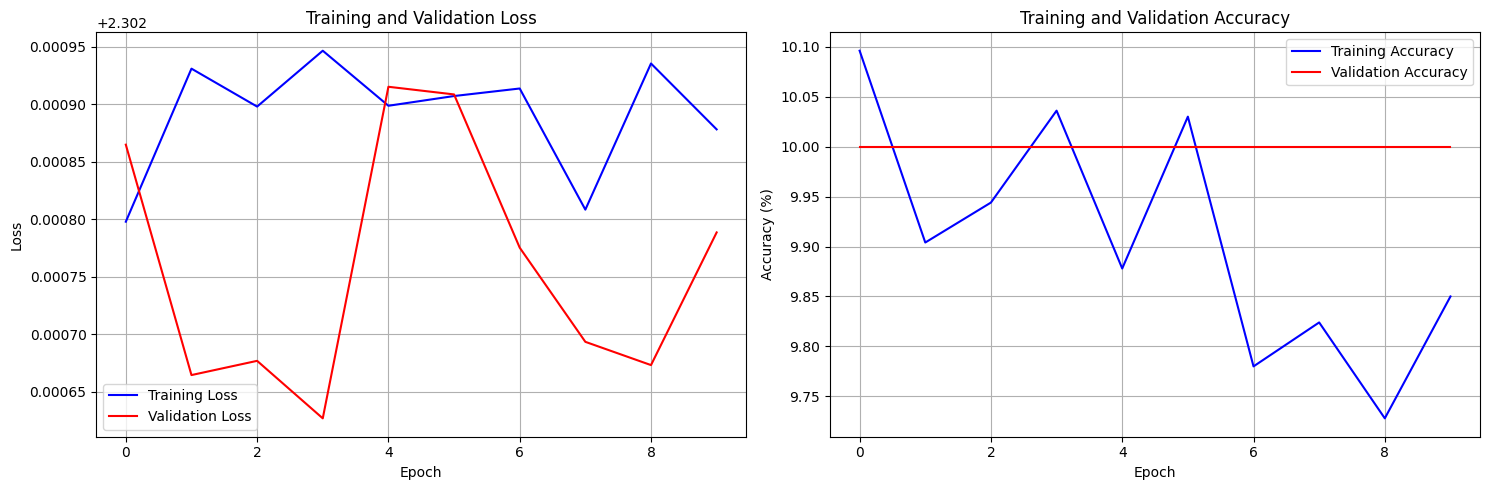

In [15]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)